# Generate Milestones in 2D spaces
In this notebook, you will learn how to visualize high dimensional trajectoreis in a low dimension space using PCA. You will also learn how to extract a reaction coordinates for protein/ligand dissociation. Finally, how to define and optimize milestones along the created reaction coordinates.

## Import Libraries

In [1]:
import sys
sys.path.append('./modules/')

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from LineBuilder import*
from findnorm import*
from Project import*
from OptMileStone import*
from CorrectXYnp import*
from RotationMatrix import*

# 1. Obtaining milestones from enhanced sampling or PSIM trajectories

## 1.1 Load metadynamics/PSIM trajectories to the notebook
In order to project high dimensional trajectories into low dimensional spaces, we start by loading the Cartesian coordinates of protein and ligand using **pytraj**.

In [2]:
# specify path of promtop and dcd files
reaction_path = '/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory'
TOP = reaction_path+'/complex.prmtop'
TRAJ = reaction_path+'/nowater.dcd'

# read the trajecory from the disk
traj = pt.iterload(TRAJ, TOP,stride=1)

## 1.2 Align the trajectory to a reference frame
We next remove rotation and translation of the protein by aligning the protein to a reference frame. We used atomic masks to specify atoms used for alignment. The system for this tutorial is a CDK8/CycC-Ligand, where residues 1-359 is CDK8, residues 360-619 is Cyclin C, and residue 620 is the ligand (resname MOL).

In this case, we used all the backbone atoms of the CDK8 protein (residues 1-359) to perform alignment. 

In [3]:
# superpose to a reference frame
refpdb = pt.load(reaction_path+'/0.pdb')
pt.superpose(traj, ref=refpdb, mask='(:1-359)&(@N,@C,@CA,@O)')

pytraj.TrajectoryIterator, 5455 frames: 
Size: 1.260987 (GB)
<Topology: 10342 atoms, 620 residues, 3 mols, non-PBC>
           

## 1.3 Reading trajectories ...
Now we need to extract the Cartesian coordinates from the trajectory, which will be used as high-d representations of the trajectory. Here, the selected Cartesian coordiates include all the alphe carbon atoms of proteins and all the heavy atoms of the ligand.  

In [4]:
# use ".xyz" attribute to print the Cartesian coordinates of the first frame
traj[:1].xyz

array([[[-19.40857793,  26.06932418,   4.29338739],
        [-19.66818952,  25.15431127,   4.74369764],
        [-19.92913749,  26.34724487,   3.43053327],
        ...,
        [  2.66375547,   0.21173051,  -9.20354013],
        [  3.07702957,  -0.19314785,  -7.15747554],
        [  4.1288673 ,  -0.53416083,  -7.33470137]]])

We will store the Cartesian coordinates in a matrix, whose dimension is num_frames\*(3\*num_select_atoms). The "3" stands for x, y, and z coordinates of each atom.

In [5]:
# read the trajectory into memory by chunk
nframe = traj.n_frames
chunksize = min([200, nframe])
nchunk = int(np.floor(nframe/chunksize))+1 if nframe%chunksize !=0 else int(np.floor(nframe/chunksize))
pile = []
for i in log_progress(range(nchunk), every=1):
    tmp = traj[i*chunksize:min((i+1)*chunksize, nframe)]['@CA,:620']['!@H*']
    pile.append(tmp.xyz.reshape(tmp.n_frames, tmp.n_atoms*3))
    
proteinUNK_2d = np.concatenate(pile,axis=0)

In [6]:
proteinUNK_2d.shape

(5455, 1953)

## 1.4 Peform PCA
Here we only generate the first two PCs by setting n_components=2

In [7]:
# PCA using sklearn
pca = PCA(n_components=2)
reduced_cartesian = pca.fit_transform(proteinUNK_2d)
print(reduced_cartesian.shape)

# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T

(5455, 2)


In [8]:
# check the ratio of explained variance 
# calculated the ratio of variance explained by the first two PCs (we expect a least 0.75)
sum(pca.explained_variance_ratio_)

0.7961944421488377

## 1.5 Visualize PCs of the reaction

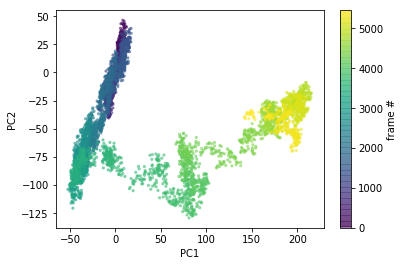

In [9]:
# set the first frame of the trajectory as an origin
refframe =  proteinUNK_2d[0,:].copy()
proteinUNK_ref_2d = proteinUNK_2d - refframe

# project high-d Cartesian coordinates into low-d PCs
projections=np.concatenate((np.dot(proteinUNK_ref_2d, eigvecs[:,0]).reshape(len(proteinUNK_ref_2d),1),
                            np.dot(proteinUNK_ref_2d, eigvecs[:,1]).reshape(len(proteinUNK_ref_2d),1)),
                           axis=1)
# plot results
plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('frame #')

## 1.6 Obtain final reaction path

### 1.6.1 Generate smooth trajectory
We then use the low-d projections to sketch a reaction coordinate. A smooth path is generated by averaging frames in the before and after 100 steps of each frame,

In [10]:
smoothpath=[]
for i in range(len(projections)):
    istart=max(0,i-100)
    iend=min(len(projections)-1,i+100)
    smoothpath.append(projections[istart:iend].mean(axis=0))
smoothpath=np.asarray(smoothpath)

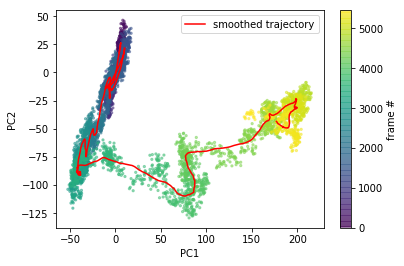

In [11]:
Fig=plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('frame #')

plt.plot(smoothpath[:,0],smoothpath[:,1],
            color='r',label='smoothed trajectory')
plt.legend()
plt.show()

### 1.6.2 Detemine reaction path
Next, we are going to use a interactive tool to refine the reactioon path by avoiding the convoluted loops. Note that we call the interactive ploting interface using **matplotlib notebbok**. However, sometimes it takes multiple attempts to activate the interactive interface, i.e. you need to execute this cell multiple times until the interactive graphic panel comes up. Once the drawing panel comes up, use your mouse to move the cruiser, and left click to add green point along the smooth path. Note that all the convoluted loops should be escape. Once finished, move one to the next cell.

<IPython.core.display.Javascript object>


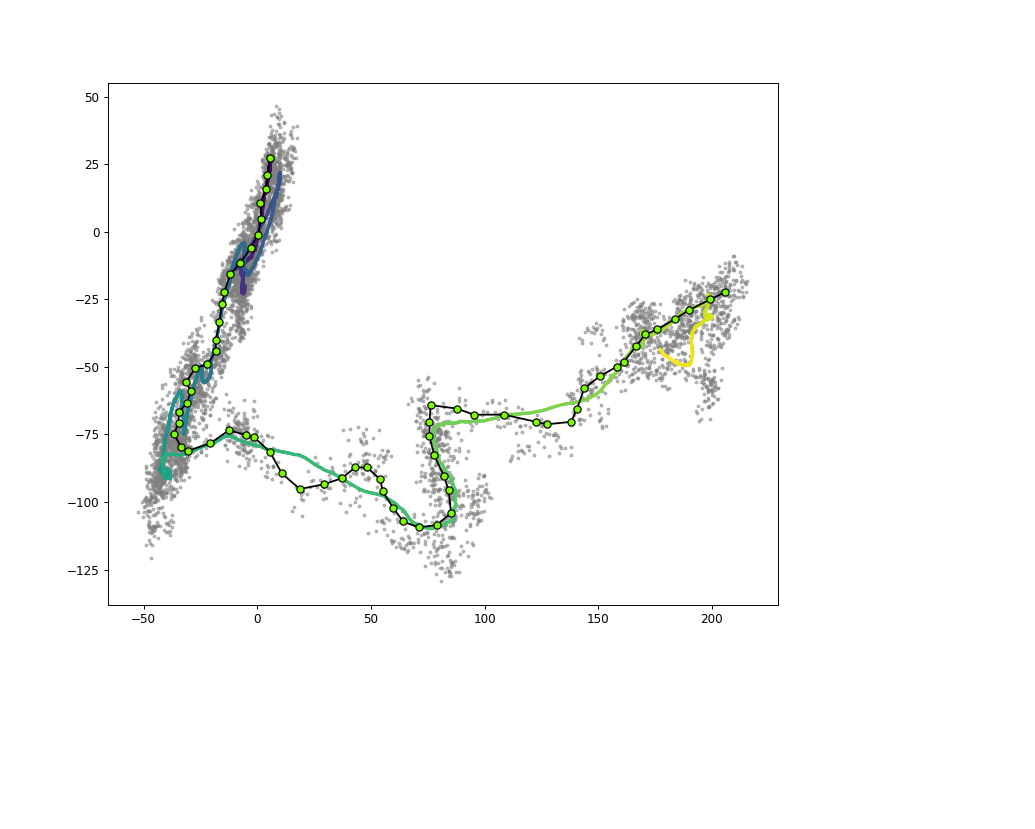

In [31]:
%matplotlib notebook
 
fig = plt.figure(figsize=(10,8))
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5, c='gray',
        alpha=0.5, zorder=0
        )
plt.scatter(smoothpath[:,0],smoothpath[:,1],s=3,
            c=range(int(len(proteinUNK_2d))),
            label='smoothed trajectory',
            zorder=5
           )
line, = plt.plot([], [],marker='o',color='k',markerfacecolor='lawngreen', zorder=10)  # empty line
linebuilder = LineBuilder(line)
plt.show()

save temporary path (positions of the green dots)

In [12]:
path_id = 0  # specify which path you want to write/load

In [34]:
milestone_path=reaction_path+'/Milestone_%d'%path_id
%mkdir {milestone_path}

x1 = np.array([linebuilder.xs]).T
x2 = np.array([linebuilder.ys]).T
idx = np.array([range(len(x1))]).T
path_noloop = np.hstack((idx,x1))
path_noloop = np.hstack((path_noloop,x2))

#write path to temppath.txt
test = open(milestone_path+'/temppath.txt', "w+")
for i in range(len(path_noloop)):
    print("%s\t%s\t%s" %(i,path_noloop[i,1],path_noloop[i,2]), file=test)
test.close()

mkdir: cannot create directory ‘/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory/Milestone_0’: File exists


load the temporary path

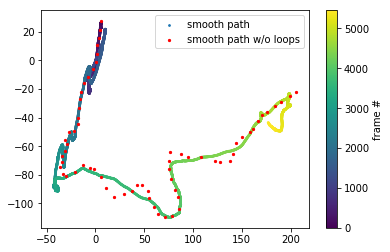

In [13]:
%matplotlib inline

milestone_path=reaction_path+'/Milestone_%d'%path_id
path_noloop = np.asarray( pd.read_csv(milestone_path+'/temppath.txt', header=None, delimiter=r"\s+") )

fig = plt.figure()
plt.scatter(smoothpath[:,0],smoothpath[:,1],s=3,
            c=range(int(len(proteinUNK_2d))),label='smooth path')
cbar = plt.colorbar()
cbar.set_label('frame #')

plt.scatter(path_noloop[:,1],path_noloop[:,2],s=5,c='r', label='smooth path w/o loops')
plt.legend()
plt.show()

### 1.6.3 Path Interpolation
Now we have generated a few nodes along the smooth path, but the interval between nodes are still quite large. We use spline interpolation to connect nodes and generate a final smooth path w/o loops.

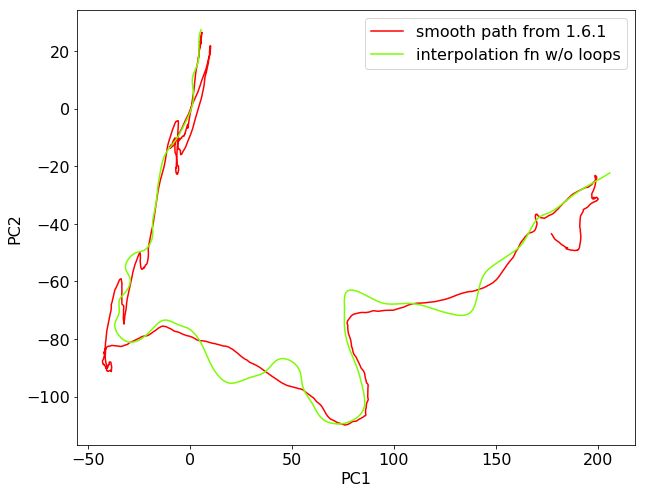

In [14]:
#path interpolation
%matplotlib inline
finalpath = interpolateCurve(np.asarray(path_noloop),500)
plt.figure(figsize=(10,8))
plt.plot(smoothpath[:,0],smoothpath[:,1],
        color='r',label='smooth path from 1.6.1')
plt.plot(finalpath[:,0],finalpath[:,1],
         color='lawngreen',label='interpolation fn w/o loops') #interpolation fn
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

### 1.6.4 Fine tune the final path
By default, the interpolated smooth curve contains 500 points, we select one of every n_milestone points as a center of milestones 

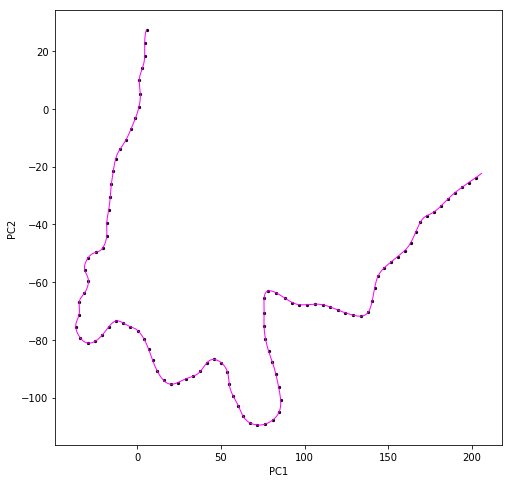

In [15]:
n_milestone = 5
fp = finalpath[::n_milestone]

finalpath = interpolateCurve(np.asarray(path_noloop),500)
plt.figure(figsize=(8,8))
plt.scatter(fp[:,0],fp[:,1],marker='o',s=5,c='k') #dots
plt.plot(finalpath[:,0],finalpath[:,1],color='magenta',linewidth=1) #interpolation fn
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Save the centers of milestones as finalpath.txt. You run this cell "ONLY" when the you create the center of the milestones. If you've already generated the finalpath.txt previously, then skip this cell.

In [43]:
file = open(milestone_path+'/finalpath.txt', "w+")
for i in range(len(fp)):
    print("%s\t%s\t%s" %(i,fp[i,0],fp[i,1]), file=file)
file.close()

Load the saved finalpath.txt

In [16]:
path = pd.read_csv(milestone_path+'/finalpath.txt', header=None, delimiter=r"\s+")
fp = np.asarray(path)
fp = fp[:,1:3]
fp.shape

(100, 2)

#### Now let's put everything we've worked out so far together. The percentage in the plotting panel is the ratio of variance explained by PC1 and PC2.

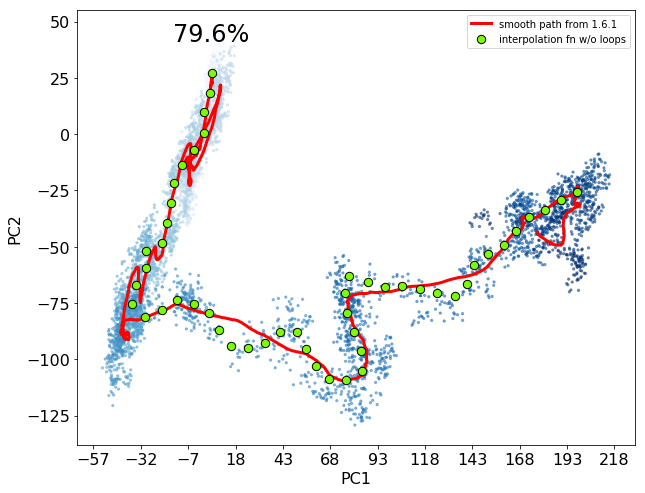

In [17]:
sum_var = sum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5, zorder=0, cmap='Blues'
        )
# plt.blue()

plt.plot(smoothpath[:,0],smoothpath[:,1],linewidth=3,
        color='r',label='smooth path from 1.6.1', zorder=5)

plt.scatter(fp[::2,0],fp[::2,1],
         c='lawngreen',s=70,
        edgecolor='k',label='interpolation fn w/o loops',zorder=10) #interpolation fn

plt.annotate(s="%.1f"%(sum_var*100)+'%',
             xy=(-15,max(projections[:,1])-5),
             **dict(size=24, color='k'))
ax.set_xticks(range(int(min(projections[:,0]))-5, int(max(projections[:,0]))+5, 25))

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

## 1.7 Find initial milestones as a norm of the smoothed path
Initially, milestone lines are simply vertical lines with length = sc along the final smooth path. Without furthur optimization, several milestone lines overlap.

In [147]:
# generate norms along the path
slope = findnorm(fp)
slope_opt = np.empty_like(slope)
slope_opt[:]=slope

# radiaus = sc/2
sc = 20 

# coordinates of milestones on the path
X = fp[:,0].reshape(len(fp),1)
Y = fp[:,1].reshape(len(fp),1)

# slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)

# boundary of milestones in x-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2)).reshape(len(fp),1)
Xp = X + dX
Xn = X - dX

# boundary of milestones in y-axis Nx1
Yp = Y + np.dot(M,dX)
Yn = Y - np.dot(M,dX)
CorrectXYnp(Xp,Yp,Xn,Yn, slope_opt)

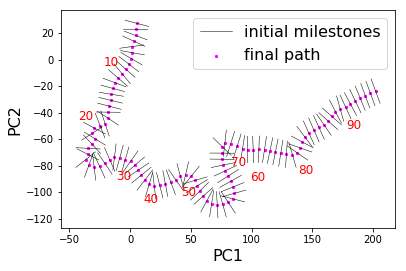

In [148]:
plt.figure()
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

## 1.8 Optimize the slopes of the milestones to minimize overlapping
Here we perform both global and local optimization of the slopes of milestones to 1) avoid crossing of milestone and 2) to make sure all the milestone cells are trapezoid. 2) is critical for the later algorithm used for indexing frames according to their projections on the PC1/PC2 space. 

### global optimization
All the milestones will be adjusted simultanesouly to minimize overlapping. The **OptMileStone** module will adjust slopes of all the milestones *n_iter* times. Warning: the global optimization algorithm is not perfect. If you set *n_iter* too large, milestones will look very funny. In contrast, you should set *n_iter* 0-20, and check the milestones everytime. This part should be repeated until you start seeing weird transformation of the milestones.

When you reach the limit of the global optimization (either it stops improving or becomes worse), you should stop and move on to the **local optimization** to manually adjust the rest of the milestones if needed.

In [165]:
n_iter = 20

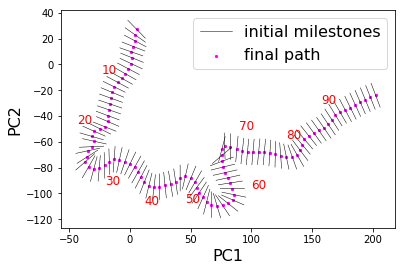

In [180]:
# Optimizing slopes of the milestones
slope_opt = OptMileStone(X,Y,Xp,Yp,Xn,Yn,slope_opt,0.05, n_iter)

#slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)
# boundary of milestones in x-axis and y-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2))
Xp, Xn = [X + dX, X - dX]
Yp, Yn = [Y + np.dot(M,dX), Y - np.dot(M,dX)]

CorrectXYnp(Xp,Yp,Xn,Yn,slope_opt)
if (X[1]-X[0] > 0 and Yp[0]-Y[0]<0) or (X[1]-X[0] < 0 and Yp[0]-Y[0]>0):
    A, B = [Xp.copy(), Yp.copy()]
    C, D = [Xn.copy(), Yn.copy()]
    Xp, Yp, Xn, Yn = [C, D, A, B]
    
# Plot adjusted milestones   
plt.figure()
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

### local optimization
In this section, you need to select certain milestone(s) whose slopes needed to be increased or decreased. First, you want to identify milestones to be adjested. By specifying the range of milestones between *ini* and *fin*, you can see the selected milestones colored in red. For example, if ini=21 and fin=25, only milestones 21, 22, 23, 24, and 25 will be adjusted.

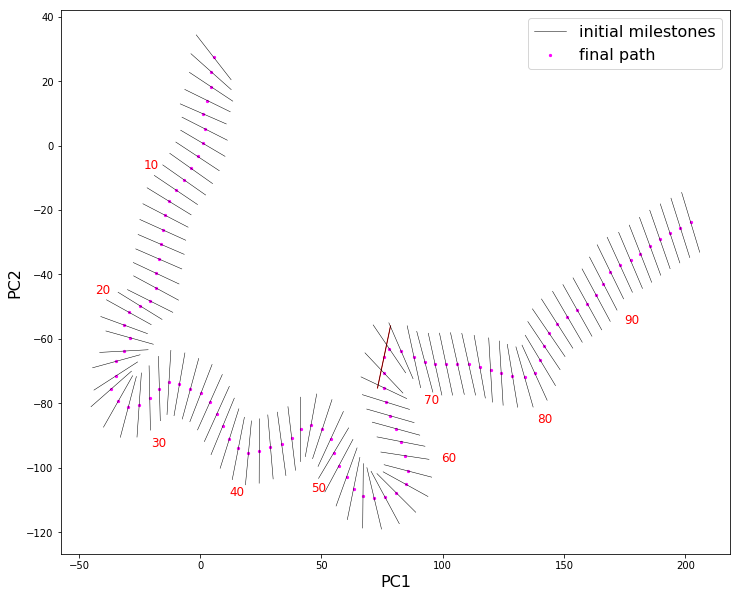

In [244]:
ini, fin = [67,67] # specify milestones to proceed the local optimization  

plt.figure(figsize=(12,10))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(ini, fin+1):
    plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='r', linewidth=1, zorder=2)

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

If you want to increase the slopes of the selected milestones, set increase = True. Set increase = False to decrease the slopes. You can also specify the strength of the local optimization. The *strength* range from 0 to 0.99, the higher the strength the more the slope change. You can also invert the sign of the slope by specifying *flip = True*.

In [234]:
slope_opt[ini]

array([-35.17730173])

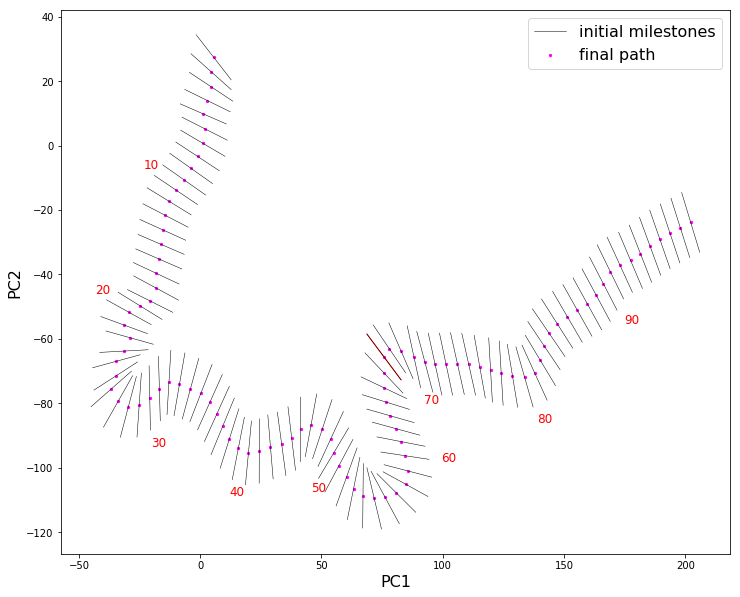

In [251]:
flip = False
increase = False
strength = 0.1


for i in range(ini, fin+1):
    if flip:
        slope_opt[i] *= -1
    if increase:
        slope_opt[i] /= (1-strength) 
    else:
        slope_opt[i] *= (1-strength)

#slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)
# boundary of milestones in x-axis and y-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2))
Xp, Xn = [X + dX, X - dX]
Yp, Yn = [Y + np.dot(M,dX), Y - np.dot(M,dX)]

CorrectXYnp(Xp,Yp,Xn,Yn, slope_opt)
if (X[1]-X[0] > 0 and Yp[0]-Y[0]<0) or (X[1]-X[0] < 0 and Yp[0]-Y[0]>0):
    A, B = [Xp.copy(), Yp.copy()]
    C, D = [Xn.copy(), Yn.copy()]
    Xp, Yp, Xn, Yn = [C, D, A, B]
    
# Plot adjusted milestones   
plt.figure(figsize=(12,10))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(ini, fin+1):
    plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='r', linewidth=1, zorder=2)

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

Once you are satisfied with the milestone lines, save the slopes of each milestone in milestone_slopes.npy. You only need to run this cell when building the milestone lines.

In [252]:
np.save(milestone_path+'milestone_slopes.npy',slope_opt)

Load the optimized milestone slopes. Once you've saved the optimized milestone slope, you can use it to construct the milestone everytime.

In [253]:
slope_opt = np.load(milestone_path+'milestone_slopes.npy')

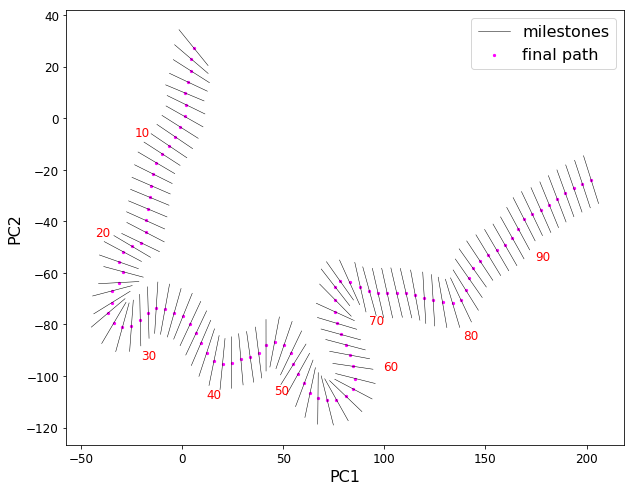

In [254]:
plt.figure(figsize=(10,8))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params(labelsize=12)
plt.show()